In [1]:
import mesa
from mesa import Model, Agent
from mesa.datacollection import DataCollector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from DataMarket_persona import DataMarket, Participants
from mesa.batchrunner import batch_run

/Users/oyama-kenshin/Desktop/Vault/05_Codes/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
persona_distribution = {'intrinsic': 0.2, 'follower': 0.8}
wealth_params = (3.0, 100)  # α=2.5, scale=100
w1_params = [(2.0, 100)]     # α=2.0

In [3]:
# test_model = DataMarket(
#     num_agents=1000,
#     num_data=1000,
#     initial_price = 150, 
#     tau = 0.2,
#     base_wealth=100,
#     persona_dist=persona_distribution,
#     wealth_params=wealth_params,
#     w1_params=w1_params,
#     seed=42)

# for _ in range(50):
#     test_model.step()
#     print(f"Step {_+1} complete. Total sold tokens: {test_model.sold_tokens}, Provider revenue: {test_model.provider_revenue}")

# 全体レンジ（10刻み）
base_prices = [10 * i for i in range(1, 41)]  # 10, 20, ..., 400

# 詳細レンジ（2刻み）
fine_prices = list(range(80, 121, 2))  # 80, 82, 84, ..., 120

# 結合して重複除去・ソート
initial_price_list = sorted(set(base_prices + fine_prices))


params = {
    "num_agents":1000,
    "num_data": 1000,
    "initial_price": initial_price_list,
    "tau": 0.1,
    "base_wealth": 10,
    "persona_dist": [persona_distribution],
    "wealth_alpha": 3.0,
    "wealth_scale": 100,
    "w1_params": w1_params,

    "seed": 42
}
results = batch_run(
    model_cls=DataMarket,
    parameters=params,
    iterations=3,           # 各価格につき 5回繰り返す
    max_steps=50,           # 各シミュレーションのステップ数上限
    number_processes=None,   # CPU 全て使いたいなら None
    data_collection_period=1,
    display_progress=True,
)

results_df = pd.DataFrame(results)




100%|██████████| 168/168 [00:27<00:00,  6.20it/s]


In [4]:
print(results[0].keys())

dict_keys(['RunId', 'iteration', 'Step', 'num_agents', 'num_data', 'initial_price', 'tau', 'base_wealth', 'persona_dist', 'wealth_alpha', 'wealth_scale', 'w1_params', 'seed', 'Holders', 'ProviderRevenue', 'AgentID', 'w_1', 'w_n', 'l_n_minus_1', 'HasToken', 'Wealth', 'Persona', 'BoughtStep'])


In [5]:
# Get the collected data from the model
# results_df = test_model.datacollector.get_model_vars_dataframe()

# Plot the results
# plt.style.use('seaborn-v0_8-whitegrid')
# plt.figure(figsize=(10, 6))

# Plot the number of holders over time
# plt.plot(results_df.index, results_df['Holders'], marker='o', linestyle='-')

# plt.title('Adoption Curve: Total Holders Over Time')
# plt.xlabel('Step')
# plt.ylabel('Number of Holders')
# plt.grid(True)
# plt.show()

In [6]:
all_buyers = [
    {
        'w_1': agent.w_1,
        'l_n_minus_1': agent.l_n_minus_1,
        'bought_step': agent.bought_step
    }
    for agent in test_model.participants if agent.has_token
]

if all_buyers:
    buyers_df = pd.DataFrame(all_buyers)

    total_buyers = len(buyers_df)
    early_thershold = total_buyers // 3
    mid_thershold = (total_buyers * 2) // 3

    def assign_period(step):
        if step <= early_thershold:
            return 'Early'
        elif step <= mid_thershold:
            return 'Mid'
        else:
            return 'Late'

    buyers_df['Period'] = buyers_df.index.to_series().apply(assign_period)
    print(buyers_df['Period'].value_counts())

    period_orders = ['Early', 'Mid', 'Late']

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 8))

    sns.scatterplot(data=buyers_df, x='w_1', y='l_n_minus_1', hue='Period', palette='Set1', hue_order=period_orders, s=100, alpha=0.7)



NameError: name 'test_model' is not defined

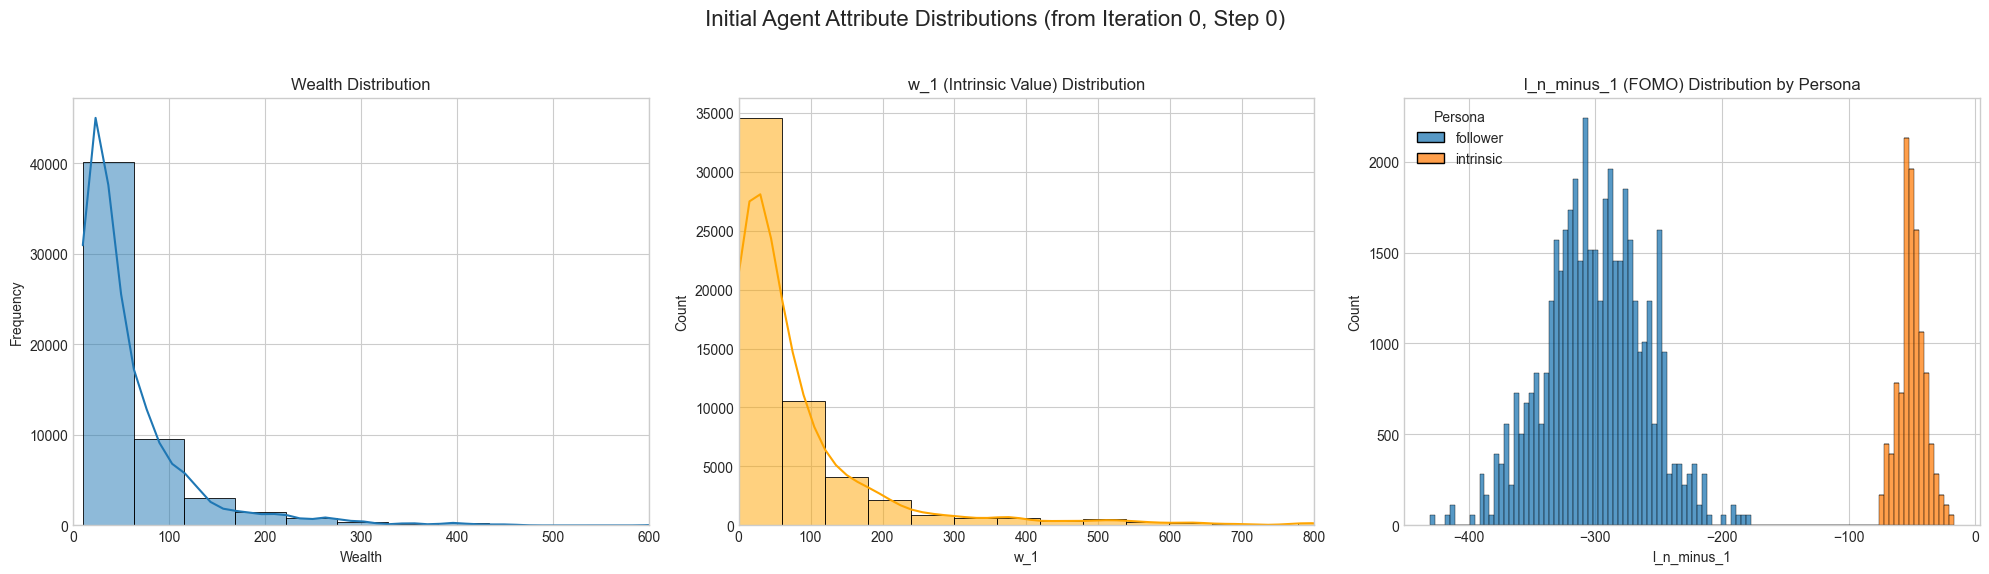

【初期状態の記述統計量 (Iteration 0, Step 0)】
             Wealth           w_1   l_n_minus_1
count  56000.000000  56000.000000  56000.000000
mean      60.768790     98.379492   -249.787059
std      107.592586    216.056237    105.998006
min       10.040039      0.110029   -430.444310
25%       20.602300     15.335968   -319.250321
50%       36.328917     40.131228   -286.746524
75%       70.971611     94.148668   -243.959795
max     2657.810429   2988.508301    -17.084973

【ペルソナ別の初期l_n_minus_1統計量】
             count        mean        std         min         25%         50%  \
Persona                                                                         
follower   44800.0 -299.767966  39.085841 -430.444310 -325.492332 -300.053343   
intrinsic  11200.0  -49.863430  10.217391  -72.473937  -55.635494  -50.317628   

                  75%         max  
Persona                            
follower  -273.030796 -180.654083  
intrinsic  -44.166108  -17.084973  


In [7]:
# 1. 最初のイテレーションの初期状態(Step 0)におけるエージェント属性を抽出
# 各イテレーションで初期分布は同じなため、iteration 0 のデータのみ使用します。
def initial_agents():
    initial_agents_df = results_df[(results_df['iteration'] == 0) & (results_df['Step'] == 0)].copy()

    # 2. 属性分布をプロット
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Initial Agent Attribute Distributions (from Iteration 0, Step 0)', fontsize=16)

    # Wealth の分布
    sns.histplot(initial_agents_df['Wealth'], kde=True, ax=axes[0], bins=50)
    axes[0].set_title('Wealth Distribution')
    axes[0].set_xlabel('Wealth')
    axes[0].set_ylabel('Frequency')
    axes[0].set_xlim(0, 600)

    # w_1 の分布
    sns.histplot(initial_agents_df['w_1'], kde=True, ax=axes[1], bins=50, color='orange')
    axes[1].set_title('w_1 (Intrinsic Value) Distribution')
    axes[1].set_xlabel('w_1')
    axes[1].set_xlim(0, 800)

    # l_n_minus_1 の分布 (ペルソナ別)
    sns.histplot(data=initial_agents_df, x='l_n_minus_1', hue='Persona', multiple='stack', ax=axes[2])
    axes[2].set_title('l_n_minus_1 (FOMO) Distribution by Persona')
    axes[2].set_xlabel('l_n_minus_1')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # 3. 参考：記述統計量を表示
    print("【初期状態の記述統計量 (Iteration 0, Step 0)】")
    print(initial_agents_df[['Wealth', 'w_1', 'l_n_minus_1']].describe())

    print("\n【ペルソナ別の初期l_n_minus_1統計量】")
    print(initial_agents_df.groupby('Persona')['l_n_minus_1'].describe())

initial_agents()


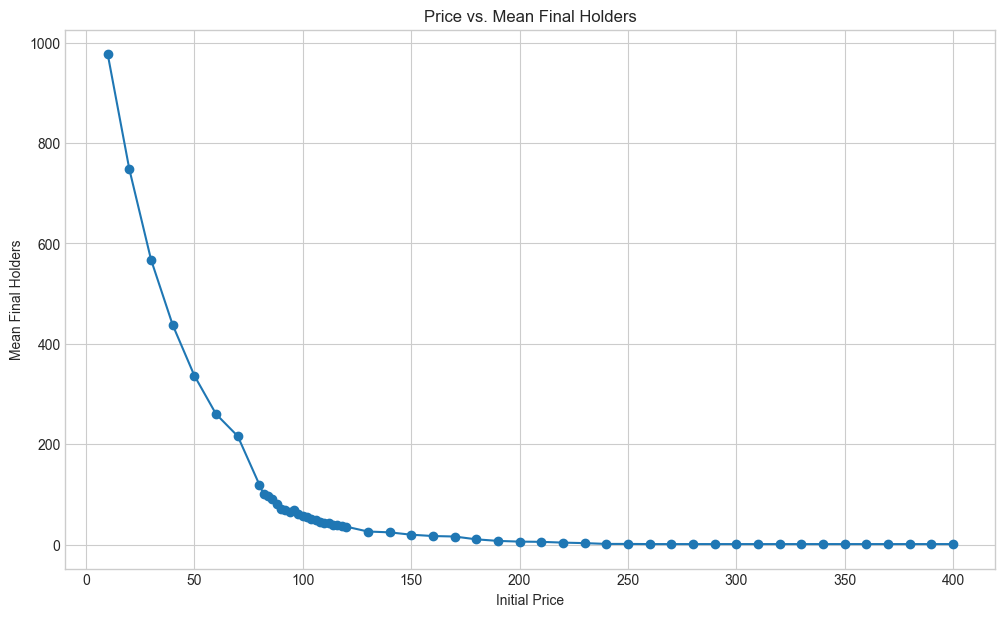

価格ごとの平均最終購入者数:
initial_price
10     977.078431
20     747.431373
30     567.490196
40     437.313725
50     336.431373
60     259.843137
70     215.960784
80     119.098039
82     100.019608
84      96.392157
86      91.294118
88      80.666667
90      71.490196
92      69.823529
94      65.156863
96      69.333333
98      60.490196
100     57.176471
102     54.254902
104     51.529412
106     48.470588
108     45.784314
110     43.039216
112     42.725490
114     39.941176
116     39.607843
118     37.509804
120     35.745098
130     26.019608
140     24.372549
150     19.666667
160     17.019608
170     16.058824
180     10.450980
190      7.333333
200      5.882353
210      5.450980
220      3.901961
230      2.882353
240      1.294118
250      1.294118
260      0.980392
270      0.980392
280      0.980392
290      0.980392
300      0.980392
310      0.980392
320      0.980392
330      0.980392
340      0.980392
350      0.980392
360      0.980392
370      0.980392
380      0.980392

In [8]:
# 1. 価格ごとに最終購入者数の平均を計算
def final_holders():
    mean_holders_by_price = results_df.groupby('initial_price')['Holders'].mean()

    # 2. 折れ線グラフで可視化
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    mean_holders_by_price.plot(
        kind='line',
        ax=ax,
        marker='o',
        title='Price vs. Mean Final Holders',
    )

    ax.set_xlabel('Initial Price')
    ax.set_ylabel('Mean Final Holders')
    plt.grid(True)
    plt.show()

    # 3. 結果のテーブルも表示
    print("価格ごとの平均最終購入者数:")
    print(mean_holders_by_price)

final_holders()


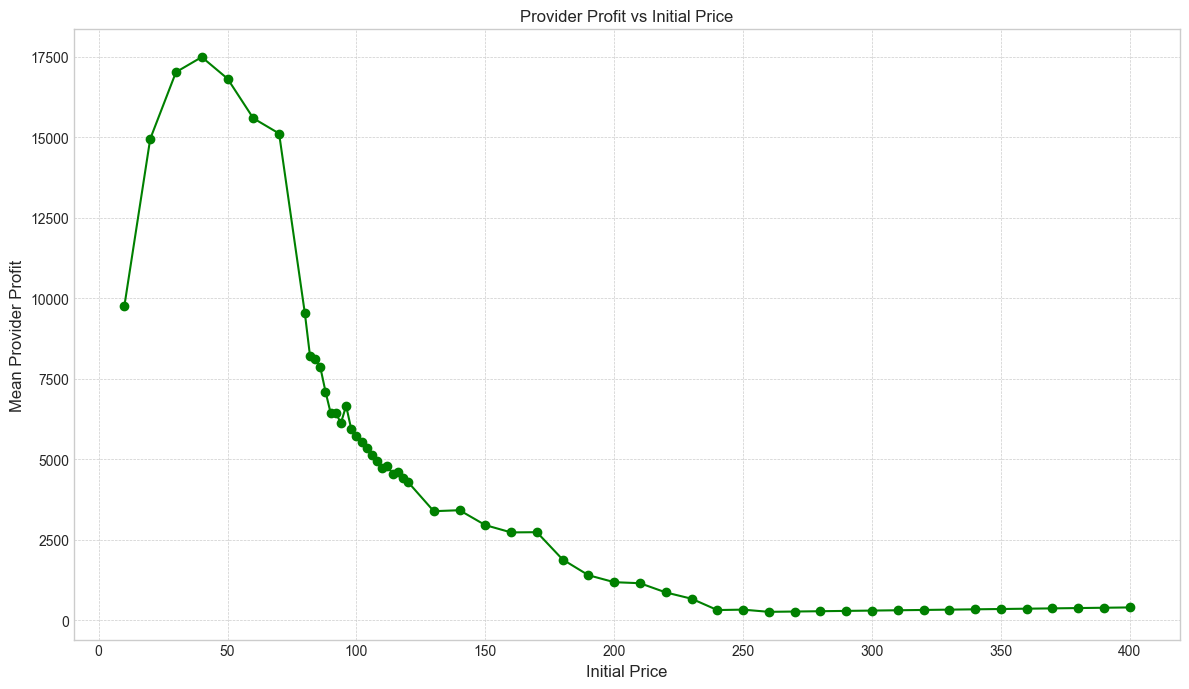

価格ごとの平均提供者利益:
initial_price
10      9770.784314
20     14948.627451
30     17024.705882
40     17492.549020
50     16821.568627
60     15590.588235
70     15117.254902
80      9527.843137
82      8201.607843
84      8096.941176
86      7851.294118
88      7098.666667
90      6434.117647
92      6423.764706
94      6124.745098
96      6656.000000
98      5928.039216
100     5717.647059
102     5534.000000
104     5359.058824
106     5137.882353
108     4944.705882
110     4734.313725
112     4785.254902
114     4553.294118
116     4594.509804
118     4426.156863
120     4289.411765
130     3382.549020
140     3412.156863
150     2950.000000
160     2723.137255
170     2730.000000
180     1881.176471
190     1393.333333
200     1176.470588
210     1144.705882
220      858.431373
230      662.941176
240      310.588235
250      323.529412
260      254.901961
270      264.705882
280      274.509804
290      284.313725
300      294.117647
310      303.921569
320      313.725490
330      323

In [9]:
def provider_profit():

    # 1. 価格ごとに提供者利益の平均を計算
    # 'Provider_Revenue' は、BatchRunnerで設定した列名に合わせてください。
    mean_revenue_by_price = results_df.groupby('initial_price')['ProviderRevenue'].mean()

    # --- グラフ描画 ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    mean_revenue_by_price.plot(
        kind='line',
        ax=ax,
        marker='o',
        color='green',
        title='Provider Profit vs Initial Price'
    )

    ax.set_xlabel('Initial Price', fontsize=12)
    ax.set_ylabel('Mean Provider Profit', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # --- 結果のテーブルも表示 ---
    print("価格ごとの平均提供者利益:")
    print(mean_revenue_by_price)

provider_profit()

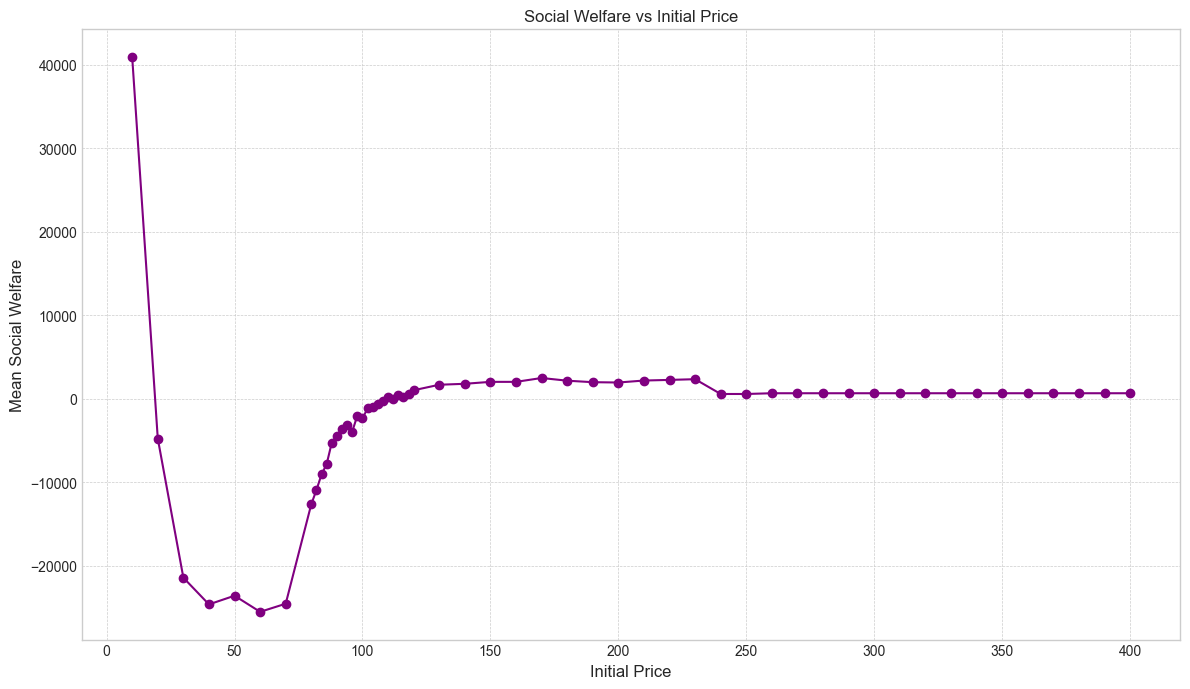

価格ごとの平均社会的厚生:
initial_price
10     40937.235249
20     -4754.836250
30    -21424.557693
40    -24625.757546
50    -23585.028871
60    -25517.876574
70    -24544.291556
80    -12619.120581
82    -10933.525332
84     -9056.499883
86     -7819.912223
88     -5254.718754
90     -4396.672880
92     -3633.564878
94     -3193.743030
96     -3924.879394
98     -2001.488556
100    -2334.263242
102    -1152.604864
104     -935.474540
106     -593.126608
108     -283.020679
110      179.914770
112      -34.994037
114      405.372172
116      232.916940
118      563.829173
120     1026.028914
130     1685.446261
140     1799.752118
150     2031.921591
160     2031.412378
170     2494.264558
180     2171.631946
190     1992.390026
200     1954.159908
210     2190.135727
220     2265.753712
230     2351.127150
240      578.850315
250      578.850315
260      668.156079
270      668.156079
280      668.156079
290      668.156079
300      668.156079
310      668.156079
320      668.156079
330      668

In [10]:
def social_welfare():
    # --- データ準備 ---
    # 最終ステップ番号を取得
    final_step = results_df['Step'].max()
    # 最終ステップの全エージェントのデータを抽出
    final_step_df = results_df[results_df['Step'] == final_step].copy()

    # 各Run（シミュレーションの各試行）の最終的な購入者数(k_final)を計算
    k_final_per_run = final_step_df.groupby('RunId')['HasToken'].sum()

    # 各エージェントのデータに、所属するRunのk_final情報を結合
    final_step_df = final_step_df.join(k_final_per_run.rename('k_final'), on='RunId')

    # --- 各エージェントの最終効用を計算する関数 ---
    def calculate_final_utility(row):
        # モデルの総エージェント数 (定数)
        n = 1000 
        k = row['k_final']
        
        if row['HasToken']: # 購入者の場合
            # W(k) = w_1 - (w_1 - w_n) * (k / (n-1))
            utility = row['w_1'] - (row['w_1'] - row['w_n']) * (k / (n - 1))
        else: # 非購入者の場合
            # L(k) = l_n-1 * (k / (n-1))
            utility = row['l_n_minus_1'] * (k / (n - 1))
        return utility

    # 全エージェントに上記関数を適用して、最終効用を計算
    final_step_df['final_utility'] = final_step_df.apply(calculate_final_utility, axis=1)

    # --- 社会的厚生の計算 ---
    # RunIdごとに全エージェントの最終効用を合計し、そのRunの社会的厚生とする
    sw_per_run = final_step_df.groupby('RunId')['final_utility'].sum()

    # RunIdに対応するinitial_priceを紐付け
    run_to_price = results_df[['RunId', 'initial_price']].drop_duplicates().set_index('RunId')
    sw_per_run = sw_per_run.to_frame().join(run_to_price)

    # 価格ごとに社会的厚生の平均を計算
    mean_sw_by_price = sw_per_run.groupby('initial_price')['final_utility'].mean()

    # --- グラフ描画 ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    mean_sw_by_price.plot(
        kind='line',
        ax=ax,
        marker='o',
        color='purple',
        title='Social Welfare vs Initial Price'
    )

    ax.set_xlabel('Initial Price', fontsize=12)
    ax.set_ylabel('Mean Social Welfare', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # --- 結果のテーブルも表示 ---
    print("価格ごとの平均社会的厚生:")
    print(mean_sw_by_price)

social_welfare()

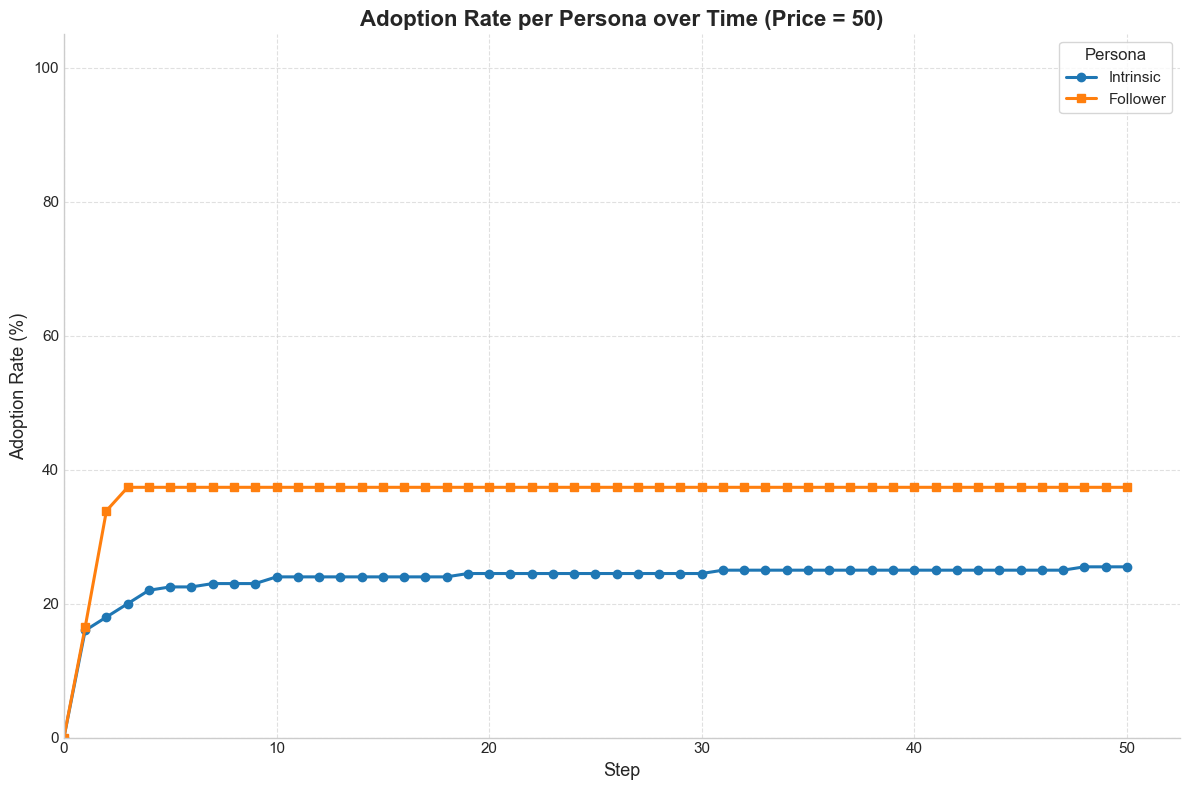

In [11]:
def adoption_rate_by_price(TARGET_PRICE=100):
    # このスクリプトは、BatchRunnerの実行が完了し、
    # 全ての結果が 'results_df' というDataFrameに格納された後に実行してください。
    # --- 1. データ抽出 ---
    # 分析対象の価格を設定

    # results_dfから、価格が100のRunId（試行ID）のリストを取得
    price_100_runs = results_df[results_df['initial_price'] == TARGET_PRICE]['RunId'].unique()

    # 該当するRunIdのデータのみを抽出
    price_100_df = results_df[results_df['RunId'].isin(price_100_runs)]

    # --- 2. データ集計 ---
    # 【重要：修正点】
    # 'Step'と'BoughtStep'が一致する行のみを抽出することで、
    # 各エージェントが「購入した瞬間」のデータのみを抜き出す。
    buyers_df = price_100_df[price_100_df['Step'] == price_100_df['BoughtStep']].copy()

    if not buyers_df.empty:
        # イテレーションごと、ステップごと、ペルソナごとの新規購入者数を計算
        new_buyers_per_step = buyers_df.groupby(['iteration', 'BoughtStep', 'Persona']).size().unstack(fill_value=0)

        # 全ステップをインデックスに設定
        max_steps = results_df['Step'].max()
        all_steps_index = pd.MultiIndex.from_product(
            [buyers_df['iteration'].unique(), range(max_steps + 1)],
            names=['iteration', 'BoughtStep']
        )
        new_buyers_per_step = new_buyers_per_step.reindex(all_steps_index, fill_value=0)

        # イテレーション（繰り返し試行）の中で、ステップごとに累積和を計算
        cumulative_buyers = new_buyers_per_step.groupby(level='iteration').cumsum()

        # イテレーション間で平均を取り、ステップごとの平均累積購入者数を算出
        mean_cumulative_buyers = cumulative_buyers.groupby(level='BoughtStep').mean()

        # ペルソナごとの総エージェント数を取得（パラメータから）
        # この部分はご自身のコードに合わせて調整してください
        num_agents = 1000 
        persona_dist = {'intrinsic': 0.2, 'follower': 0.8} 
        total_intrinsic = num_agents * persona_dist['intrinsic']
        total_follower = num_agents * persona_dist['follower']

        # 累積採用率（%）を計算
        adoption_rate = pd.DataFrame()
        if total_intrinsic > 0 and 'intrinsic' in mean_cumulative_buyers:
            adoption_rate['intrinsic'] = (mean_cumulative_buyers['intrinsic'] / total_intrinsic) * 100
        if total_follower > 0 and 'follower' in mean_cumulative_buyers:
            adoption_rate['follower'] = (mean_cumulative_buyers['follower'] / total_follower) * 100

        # --- 3. グラフ描画 ---
        plt.figure(figsize=(12, 8))
        sns.set_style("whitegrid")

        # グラフの各要素をプロット
        plt.plot(
            adoption_rate.index, adoption_rate.get('intrinsic', pd.Series(0, index=adoption_rate.index)),
            marker='o', linestyle='-', linewidth=2.2, markersize=6,
            color='#1f77b4', label='Intrinsic'
        )
        plt.plot(
            adoption_rate.index, adoption_rate.get('follower', pd.Series(0, index=adoption_rate.index)),
            marker='s', linestyle='-', linewidth=2.2, markersize=6,
            color='#ff7f0e', label='Follower'
        )

        # 軸・タイトルなどの整形
        plt.title(f'Adoption Rate per Persona over Time (Price = {TARGET_PRICE})', fontsize=16, fontweight='bold')
        plt.xlabel('Step', fontsize=13)
        plt.ylabel('Adoption Rate (%)', fontsize=13)
        plt.xticks(fontsize=11)
        plt.yticks(fontsize=11)
        plt.ylim(0, 105)
        plt.xlim(left=0)

        # グリッド・凡例・枠線調整
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(title='Persona', fontsize=11, title_fontsize=12, loc='best', frameon=True)
        for spine in ['top', 'right']:
            plt.gca().spines[spine].set_visible(False)

        plt.tight_layout()
        plt.show()

    else:

        print(f"価格が{TARGET_PRICE}のシミュレーションでは、購入したエージェントがいませんでした。")

adoption_rate_by_price(TARGET_PRICE=50)